# PIONEER ML Tutorial

This notebook demonstrates the PIONEER ML pipeline framework, Lightning utilities, and model integration. We'll:
1. Build a synthetic dataset with random characteristics (1,000 events)
2. Wrap it in a Lightning DataModule
3. Train a graph neural network model using the pipeline framework
4. Evaluate and visualize training results

**GPU Support**: The notebook uses `accelerator="auto"` which automatically detects and uses your GPU if available. If you don't have a GPU, change it to `"cpu"` in the training configuration section.

## 1) Setup Path

First, we ensure the repository root and `src/` directory are on Python's path so we can import the PIONEER ML modules.

In [1]:
import sys
import pathlib

def _find_repo_root(start: pathlib.Path) -> pathlib.Path:
    """Find the repository root by looking for pyproject.toml."""
    for path in [start, *start.parents]:
        if (path / 'pyproject.toml').exists():
            return path
    return start

repo_root = _find_repo_root(pathlib.Path.cwd())
src_dir = repo_root / 'src'

for candidate in (repo_root, src_dir):
    if str(candidate) not in sys.path:
        sys.path.insert(0, str(candidate))

print(f'Repository root: {repo_root}')
print(f'Source directory: {src_dir}')

Repository root: /home/jack/python_projects/pioneerML
Source directory: /home/jack/python_projects/pioneerML/src


## 2) Import Dependencies

Now we import the necessary libraries and PIONEER ML modules:
- **NumPy & PyTorch**: For numerical operations and tensor manipulation
- **Data modules**: `GraphGroupDataset` for handling graph-structured particle detector data
- **Model**: `GroupClassifier` - a graph neural network for multi-label classification
- **Pipeline framework**: Core components for building and running ML pipelines
- **Training utilities**: Lightning wrappers and helper functions for training and visualization

In [2]:
import numpy as np
import torch

from pioneerml.data import GraphGroupDataset
from pioneerml.models import GroupClassifier
from pioneerml.pipelines import Context, Pipeline, StageConfig
from pioneerml.pipelines.stages import LightningTrainStage
from pioneerml.training import (
    GraphDataModule,
    GraphLightningModule,
    plot_loss_curves,
    default_precision_for_accelerator,
    CleanProgressBar,
)

In [3]:
class RawGraphGroupDataset(GraphGroupDataset):
    """GraphGroupDataset that preserves the original record on Data._raw."""
    def __getitem__(self, index):
        data = super().__getitem__(index)
        data._raw = self.items[index]
        return data


## 3) Create a Synthetic Dataset

To demonstrate the pipeline, we'll generate a small synthetic dataset that mimics particle detector data. Each record represents an event with:
- **coord**: Spatial coordinates of detector hits
- **z**: Position along the beam axis  
- **energy**: Energy deposited at each hit
- **view**: Detector view identifier (0 or 1)
- **labels**: Multi-label classification targets (e.g., particle types)

The `GraphGroupDataset` will convert these records into PyTorch Geometric graph structures suitable for graph neural networks.

In [17]:
def make_record(num_hits: int, event_id: int) -> dict:
    """Generate a synthetic detector event with random hit data."""
    coord = np.random.randn(num_hits).astype(np.float32)
    z = np.random.randn(num_hits).astype(np.float32)
    energy = np.abs(np.random.randn(num_hits)).astype(np.float32)
    view = np.random.randint(0, 2, num_hits).astype(np.float32)

    # Multi-label targets (3 classes) based on physics-inspired features
    # Class 0: High energy events (energy mean > threshold)
    # Class 1: Events with many hits (num_hits > threshold)  
    # Class 2: Localized events (spatial spread < threshold)
    
    energy_threshold = 0.8 + np.random.randn() * 0.2  # Random threshold
    hit_threshold = 15 + np.random.randint(-5, 5)     # Random threshold
    spatial_spread = np.std(coord)
    energy_mean = energy.mean()
    
    labels = [
        int(energy_mean > energy_threshold),
        int(num_hits > hit_threshold),
        int(spatial_spread < 1.0)
    ]

    return {
        "coord": coord,
        "z": z,
        "energy": energy,
        "view": view,
        "labels": labels,
        "event_id": event_id,
        "group_id": event_id,
        # Store decision boundary features for visualization
        "energy_mean": energy_mean,
        "energy_threshold": energy_threshold,
        "num_hits": num_hits,
        "hit_threshold": hit_threshold,
        "spatial_spread": spatial_spread,
    }

# Generate synthetic events with random characteristics
N_EVENTS = 1_000
np.random.seed(42)  # For reproducibility

records = [
    make_record(
        num_hits=np.random.randint(5, 40),  # Random hit count between 5-40
        event_id=i
    ) 
    for i in range(N_EVENTS)
]

dataset = RawGraphGroupDataset(records, num_classes=3)

print(f"Created dataset with {len(dataset):,} samples")
print(f"Hit count range: 5-40 hits per event")
print(f"Multi-label classification: 3 classes")

# Inspect the first graph
first_graph = dataset[0]
print(f"\nFirst graph structure:")
print(f"  Nodes: {first_graph.x.shape[0]}")
print(f"  Node features: {first_graph.x.shape[1]}")
print(f"  Labels: {first_graph.y.numpy()}")
first_graph

Created dataset with 1,000 samples
Hit count range: 5-40 hits per event
Multi-label classification: 3 classes

First graph structure:
  Nodes: 33
  Node features: 5
  Labels: [0. 1. 0.]


Data(x=[33, 5], edge_index=[2, 1056], edge_attr=[1056, 4], y=[3], event_id=0, group_id=0)

## 4) Create a Lightning DataModule

The `GraphDataModule` wraps our dataset and handles:
- **Train/validation/test splits**: Automatically partitions the data
- **PyTorch Geometric DataLoaders**: Creates batched graph loaders with proper collation
- **Multi-processing**: Configurable worker processes for data loading

This standardizes data handling across experiments and integrates seamlessly with PyTorch Lightning.

In [5]:
datamodule = GraphDataModule(
    dataset=dataset,
    batch_size=4,
    val_split=0.2,      # 20% for validation
    test_split=0.0,     # No test set for this tutorial
    num_workers=2,      # Parallel data loading workers
    pin_memory=False,   # Set to True when using GPU
)

# Setup creates the train/val splits
datamodule.setup()

# Inspect the dataloaders
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Training samples: {len(datamodule.train_dataset)}")
print(f"Validation samples: {len(datamodule.val_dataset)}")

Training batches: 200
Validation batches: 50
Training samples: 800
Validation samples: 200


## 5) Build the Model and Lightning Module

We create two components:

1. **GroupClassifier**: A graph neural network that:
   - Processes graph-structured detector data using message-passing layers
   - Aggregates node features to produce graph-level predictions
   - Outputs multi-label classification scores

2. **GraphLightningModule**: A PyTorch Lightning wrapper that:
   - Defines the training loop, validation loop, and optimizer
   - Automatically logs metrics and handles device placement
   - Tracks loss history for later visualization

In [6]:
model = GroupClassifier(
    num_classes=3,      # Multi-label classification with 3 target classes
    hidden=64,          # Hidden dimension for GNN layers
    num_blocks=2        # Number of message-passing blocks
)

lightning_module = GraphLightningModule(
    model,
    task="classification",
    lr=1e-3             # Learning rate
)

print(f"Model: {model.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
lightning_module

Model: GroupClassifier
Parameters: 118,020


GraphLightningModule(
  (model): GroupClassifier(
    (input_embed): Linear(in_features=5, out_features=64, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x FullGraphTransformerBlock(
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): TransformerConv(64, 16, heads=4)
        (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=256, out_features=64, bias=True)
        )
      )
    )
    (jk): JumpingKnowledge(cat)
    (pool): AttentionalAggregation(gate_nn=Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    ), nn=None)
    (head): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1

## 6) Build and Run the Training Pipeline

The PIONEER ML pipeline framework lets you compose complex ML workflows from reusable stages. Here we use `LightningTrainStage` which:

- Wraps PyTorch Lightning's Trainer with our model and data
- Automatically handles device placement, precision, and logging
- Stores results (trainer, trained module, metrics) in a shared `Context`
- Can be combined with other stages (preprocessing, evaluation, checkpointing, etc.)

The `Context` object acts as a shared state that flows through pipeline stages, allowing stages to pass data and results to each other.

In [7]:
# Configure training
# NOTE: Change "auto" to "cpu" if you don't have a GPU available
train_stage = LightningTrainStage(
    config=StageConfig(
        name="train",
        params={
            "module": lightning_module,
            "datamodule": datamodule,
            "trainer_params": {
                "accelerator": "auto",             # "auto" uses GPU if available, else CPU
                "devices": 1,
                "max_epochs": 5,                   # Train for 5 epochs
                # No batch limits - process all data each epoch
                "logger": False,                   # Disable external loggers
                "enable_checkpointing": False,     # No checkpointing for demo
                "precision": default_precision_for_accelerator("auto"),
                "enable_model_summary": False,     # Suppress model summary
                "enable_progress_bar": False,      # Disable default progress bar
                "callbacks": [CleanProgressBar(bar_width=25)],  # Use custom progress bar
            },
        },
    )
)

# Create and run the pipeline
pipeline = Pipeline([train_stage], name="tutorial_pipeline")
ctx = pipeline.run(Context())

# Inspect the context
print("\n=== Pipeline Context Summary ===")
print(ctx.summary())
print("\n=== Metrics ===")
print(ctx.get("metrics", {}))

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0/0 | Val:   4.0% [█░░░░░░░░░░░░░░░░░░░░░░░░] [2/50] loss=0.7555 accuracy=0.3750                                                      

Starting training for 5 epochs...
Epoch 1/5 | Train: 100.0% [█████████████████████████] [200/200] loss=0.1787 | Val: 100.0% [█████████████████████████] [50/50] loss=0.2127 accuracy=0.9167 | ETA: 32s
Epoch 2/5 | Train: 100.0% [█████████████████████████] [200/200] loss=0.1297 | Val: 100.0% [█████████████████████████] [50/50] loss=0.1710 accuracy=0.9217 | ETA: 27s
Epoch 3/5 | Train: 100.0% [█████████████████████████] [200/200] loss=0.2800 | Val: 100.0% [█████████████████████████] [50/50] loss=0.1732 accuracy=0.9233 | ETA: 16s
Epoch 4/5 | Train: 100.0% [█████████████████████████] [200/200] loss=0.0754 | Val: 100.0% [█████████████████████████] [50/50] loss=0.1630 accuracy=0.9233 | ETA: 8s
Epoch 5/5 | Train: 100.0% [█████████████████████████] [200/200] loss=0.0942 | Val: 100.0% [█████████████████████████] [50/50] loss=0.1807 accuracy=0.9217


`Trainer.fit` stopped: `max_epochs=5` reached.


Training complete! Total time: 40s

=== Pipeline Context Summary ===
{'lightning_module': {'type': 'GraphLightningModule', 'size': '56.00 B'}, 'trainer': {'type': 'Trainer', 'size': '56.00 B'}, 'model': {'type': 'GroupClassifier', 'size': '56.00 B'}, 'metrics': {'type': 'dict', 'size': '424.00 B'}}

=== Metrics ===
{'val_loss': 0.18067079782485962, 'val_accuracy': 0.9216667413711548, 'train_loss': 0.18692520260810852, 'train_accuracy': 0.9179166555404663}


## 7) Visualize Training Progress

The `GraphLightningModule` automatically tracks loss history during training.

**Understanding the training process:**
- Each **epoch** = one complete pass through all training data + one pass through all validation data
- Each **step** = processing one batch
- Training typically has more steps per epoch than validation (because we have more training samples)
- We visualize loss curves to see if the model is learning and converging

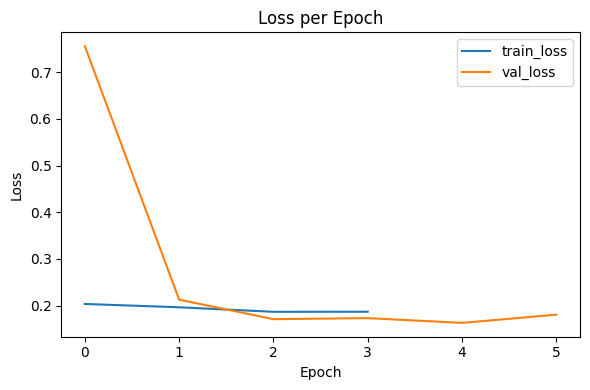


Trained for 5 epochs
Final training loss: 0.1869
Final validation loss: 0.1807


In [18]:
# Plot per-epoch loss curves (aggregated across all batches in each epoch)
if lightning_module.train_epoch_loss_history:
    plot_loss_curves(
        train_losses=lightning_module.train_epoch_loss_history,
        val_losses=lightning_module.val_epoch_loss_history,
        title='Loss per Epoch',
        xlabel='Epoch',
        show=True,
    )
    print(f"\nTrained for {len(lightning_module.train_epoch_loss_history)} epochs")
    print(f"Final training loss: {lightning_module.train_epoch_loss_history[-1]:.4f}")
    print(f"Final validation loss: {lightning_module.val_epoch_loss_history[-1]:.4f}")

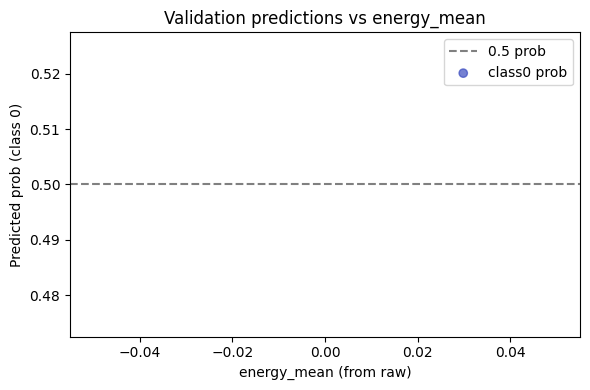

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 600x400 with 0 Axes>

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def _safe_get(raw, key, default=None):
    if hasattr(raw, key):
        return getattr(raw, key, default)
    if isinstance(raw, dict):
        return raw.get(key, default)
    return default

module = lightning_module
device = module.device
energy_means, energy_thresholds, scores = [], [], []
true_labels = []

module.eval()
with torch.no_grad():
    for batch in datamodule.val_dataloader():
        batch = batch.to(device)
        logits = module.model(batch)
        probs = torch.sigmoid(logits).cpu().numpy()
        scores.append(probs)
        true_labels.append(batch.y.cpu().numpy())
        for data in batch.to_data_list():
            raw = getattr(data, '_raw', None)
            energy_means.append(_safe_get(raw, 'energy_mean'))
            energy_thresholds.append(_safe_get(raw, 'energy_threshold'))

scores = np.concatenate(scores, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
energy_means = np.array(energy_means)
energy_thresholds = np.array(energy_thresholds)

plt.figure(figsize=(6,4))
plt.axhline(0.5, color='gray', linestyle='--', label='0.5 prob')
plt.scatter(energy_means, scores[:,0], c=(scores[:,0]>0.5), cmap='coolwarm', alpha=0.7, label='class0 prob')
plt.xlabel('energy_mean (from raw)')
plt.ylabel('Predicted prob (class 0)')
plt.title('Validation predictions vs energy_mean')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(energy_thresholds, scores[:,0], c=true_labels[:,0], cmap='coolwarm', alpha=0.7)
plt.xlabel('energy_threshold (from raw)')
plt.ylabel('Predicted prob (class 0)')
plt.title('Threshold vs predicted prob (true label color)')
plt.tight_layout()
plt.show()


## 8) Evaluate Model Predictions

Now let's see what the model actually learned! We'll:
1. Get predictions on the validation set
2. Compare predicted labels vs actual labels
3. Visualize performance with a confusion matrix for each class
4. Show specific examples to understand model behavior

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set model to evaluation mode
model.eval()

# Collect predictions and ground truth on validation set
all_preds = []
all_labels = []
all_probs = []

num_classes = 3
with torch.no_grad():
    for batch in datamodule.val_dataloader():
        batch_size = batch.num_graphs  # Number of graphs in this batch
        
        # Forward pass
        logits = model(batch)
        probs = torch.sigmoid(logits)  # Convert to probabilities
        preds = (probs > 0.5).float()  # Threshold at 0.5
        
        all_preds.append(preds.cpu().numpy())
        # batch.y is concatenated by PyG for graph-level tasks, reshape it
        labels = batch.y.cpu().numpy().reshape(batch_size, num_classes)
        all_labels.append(labels)
        all_probs.append(probs.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_probs = np.concatenate(all_probs, axis=0)

print(f"Validation set size: {len(all_labels)} samples")
print(f"Number of classes: {all_labels.shape[1]}")
print(f"\nShape details:")
print(f"  Predictions: {all_preds.shape}  (samples, classes)")
print(f"  Labels: {all_labels.shape}  (samples, classes)")
print(f"  Probabilities: {all_probs.shape}  (samples, classes)")
print(f"\nFirst few samples:")
print(f"  True labels:\n{all_labels[:3]}")
print(f"  Predictions:\n{all_preds[:3]}")

Validation set size: 200 samples
Number of classes: 3

Shape details:
  Predictions: (200, 3)  (samples, classes)
  Labels: (200, 3)  (samples, classes)
  Probabilities: (200, 3)  (samples, classes)

First few samples:
  True labels:
[[1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]]
  Predictions:
[[1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]]


/home/jack/miniconda3/envs/pioneerml-uv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


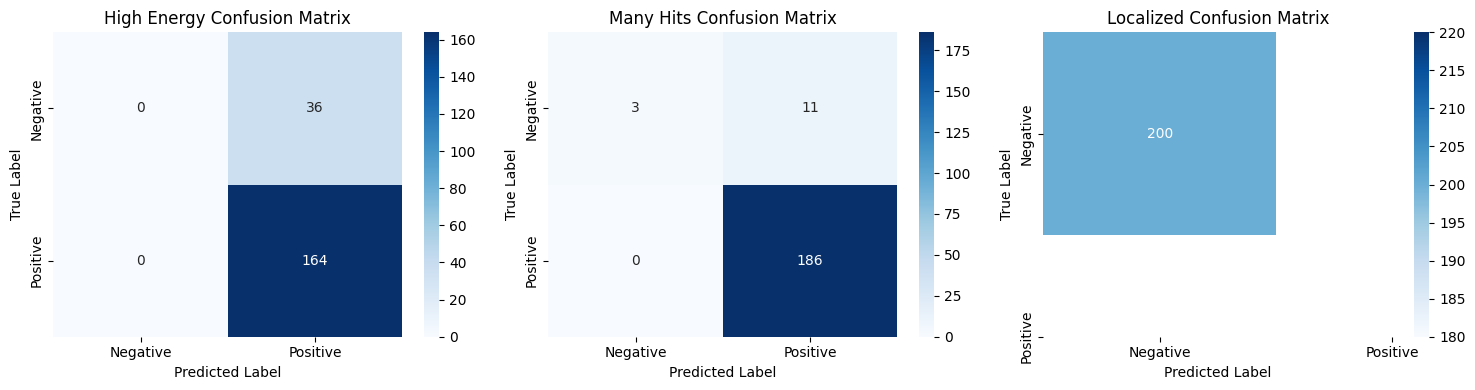


Per-class accuracies:
  High Energy: 82.00%
  Many Hits: 94.50%
  Localized: 100.00%


In [11]:
# Visualize confusion matrix for each class (multi-label classification)
class_names = ['High Energy', 'Many Hits', 'Localized']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for class_idx in range(3):
    # Extract 1D arrays for this specific class
    y_true = all_labels[:, class_idx].flatten()
    y_pred = all_preds[:, class_idx].flatten()
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[class_idx],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[class_idx].set_title(f'{class_names[class_idx]} Confusion Matrix')
    axes[class_idx].set_ylabel('True Label')
    axes[class_idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\nPer-class accuracies:")
for class_idx in range(3):
    accuracy = (all_preds[:, class_idx] == all_labels[:, class_idx]).mean()
    print(f"  {class_names[class_idx]}: {accuracy:.2%}")

In [12]:
# Show example predictions vs ground truth
num_examples = min(15, len(all_labels))  # Show up to 15 samples
print("=" * 80)
print("EXAMPLE PREDICTIONS ON VALIDATION SET")
print("=" * 80)
print(f"{'Sample':<8} {'True Labels':<20} {'Predicted Labels':<20} {'Probabilities':<30} {'Match'}")
print("-" * 80)

for i in range(num_examples):
    true_labels = all_labels[i].astype(int)
    pred_labels = all_preds[i].astype(int)
    probs = all_probs[i]
    
    # Format the output
    true_str = str(list(true_labels))
    pred_str = str(list(pred_labels))
    prob_str = f"[{probs[0]:.2f}, {probs[1]:.2f}, {probs[2]:.2f}]"
    
    # Highlight correct/incorrect predictions
    match = "✓" if np.array_equal(true_labels, pred_labels) else "✗"
    
    print(f"{i:<8} {true_str:<20} {pred_str:<20} {prob_str:<30} {match}")

print("-" * 80)

# Overall statistics
exact_match = (all_preds == all_labels).all(axis=1).mean()
per_label_accuracy = (all_preds == all_labels).mean()

print(f"\nOverall Performance:")
print(f"  Exact Match Accuracy (all 3 labels correct): {exact_match:.2%}")
print(f"  Per-Label Average Accuracy: {per_label_accuracy:.2%}")
print(f"  Total validation samples: {len(all_labels)}")

EXAMPLE PREDICTIONS ON VALIDATION SET
Sample   True Labels          Predicted Labels     Probabilities                  Match
--------------------------------------------------------------------------------
0        [np.int64(1), np.int64(1), np.int64(0)] [np.int64(1), np.int64(1), np.int64(0)] [0.83, 1.00, 0.00]             ✓
1        [np.int64(0), np.int64(1), np.int64(0)] [np.int64(1), np.int64(1), np.int64(0)] [0.82, 1.00, 0.00]             ✗
2        [np.int64(1), np.int64(1), np.int64(0)] [np.int64(1), np.int64(1), np.int64(0)] [0.93, 1.00, 0.00]             ✓
3        [np.int64(1), np.int64(1), np.int64(0)] [np.int64(1), np.int64(1), np.int64(0)] [0.98, 0.99, 0.00]             ✓
4        [np.int64(1), np.int64(1), np.int64(0)] [np.int64(1), np.int64(1), np.int64(0)] [0.94, 1.00, 0.00]             ✓
5        [np.int64(1), np.int64(1), np.int64(0)] [np.int64(1), np.int64(1), np.int64(0)] [0.80, 1.00, 0.00]             ✓
6        [np.int64(1), np.int64(1), np.int64(0)] [np.int64(1)

### Prediction Probability Distribution

Let's visualize how confident the model is in its predictions:

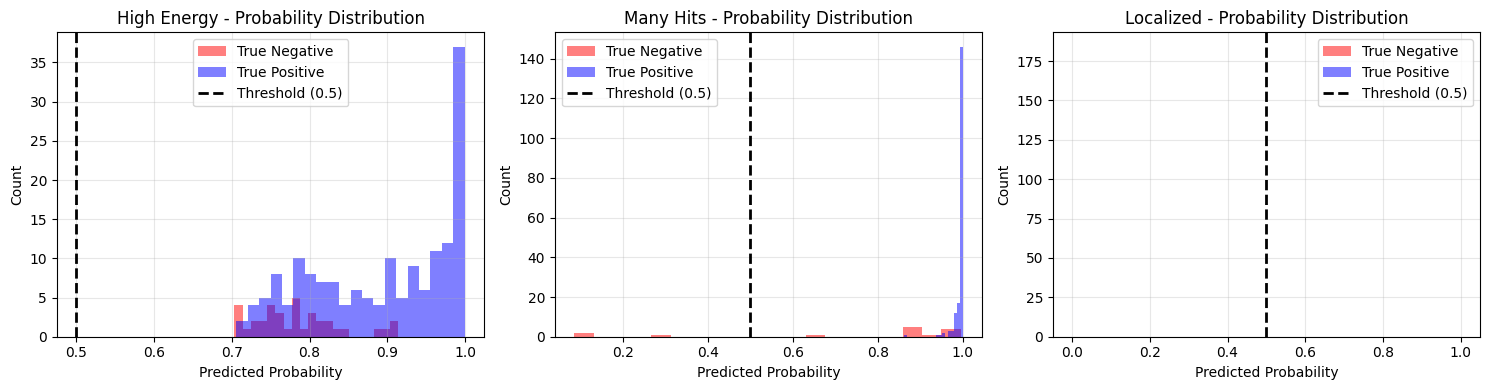


Interpretation:
- Blue bars (True Positive): Samples that actually belong to this class
- Red bars (True Negative): Samples that don't belong to this class
- Good separation = model can distinguish between classes
- Overlapping distributions = model is confused

For good performance:
  - Blue bars should cluster near 1.0 (high confidence for positives)
  - Red bars should cluster near 0.0 (low confidence for negatives)


In [13]:
# Visualize probability distributions for each class
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for class_idx in range(3):
    # Separate probabilities by true label
    pos_probs = all_probs[all_labels[:, class_idx] == 1, class_idx]
    neg_probs = all_probs[all_labels[:, class_idx] == 0, class_idx]
    
    axes[class_idx].hist(neg_probs, bins=20, alpha=0.5, label='True Negative', color='red')
    axes[class_idx].hist(pos_probs, bins=20, alpha=0.5, label='True Positive', color='blue')
    axes[class_idx].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
    axes[class_idx].set_xlabel('Predicted Probability')
    axes[class_idx].set_ylabel('Count')
    axes[class_idx].set_title(f'{class_names[class_idx]} - Probability Distribution')
    axes[class_idx].legend()
    axes[class_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Blue bars (True Positive): Samples that actually belong to this class")
print("- Red bars (True Negative): Samples that don't belong to this class")
print("- Good separation = model can distinguish between classes")
print("- Overlapping distributions = model is confused")
print("\nFor good performance:")
print("  - Blue bars should cluster near 1.0 (high confidence for positives)")
print("  - Red bars should cluster near 0.0 (low confidence for negatives)")

## 9) Next Steps

Now that you've seen the complete workflow including training, evaluation, and decision boundary visualization, here are some ways to extend this tutorial:

**Data & Models:**
- Replace the synthetic dataset with real detector data or your own domain-specific data
- Try different model architectures (adjust `hidden`, `num_blocks`, or use different models)
- Experiment with different hyperparameters (learning rate, batch size, epochs)

**Pipeline Stages:**
- Add preprocessing stages for data augmentation or feature engineering
- Include evaluation stages for metrics computation and model analysis
- Add checkpointing stages to save model weights periodically
- Chain multiple stages together for end-to-end workflows

**Experiment Tracking:**
- Enable PyTorch Lightning loggers (TensorBoard, Weights & Biases, etc.)
- Configure the `trainer_params` to use different accelerators (GPU, MPS)
- Use mixed precision training (`precision="16-mixed"`) for faster training on compatible hardware

**Production:**
- Build custom pipeline stages for your specific use cases
- Integrate with MLOps tools for deployment and monitoring
- Scale up with distributed training across multiple GPUs

### Decision Boundary Visualization

Now let's visualize how the model makes decisions compared to the ground truth thresholds. For each of the 3 classification tasks, we'll plot:
- **Sample values** (energy, hit count, spatial spread) on the y-axis
- **Sample index** on the x-axis
- **Color** shows the model's prediction (green = class 1, red = class 0)
- **Blue line** shows the ground truth decision boundary
- **Red X** marks incorrect predictions

This helps us understand if the model is learning the actual decision boundaries or just memorizing patterns.

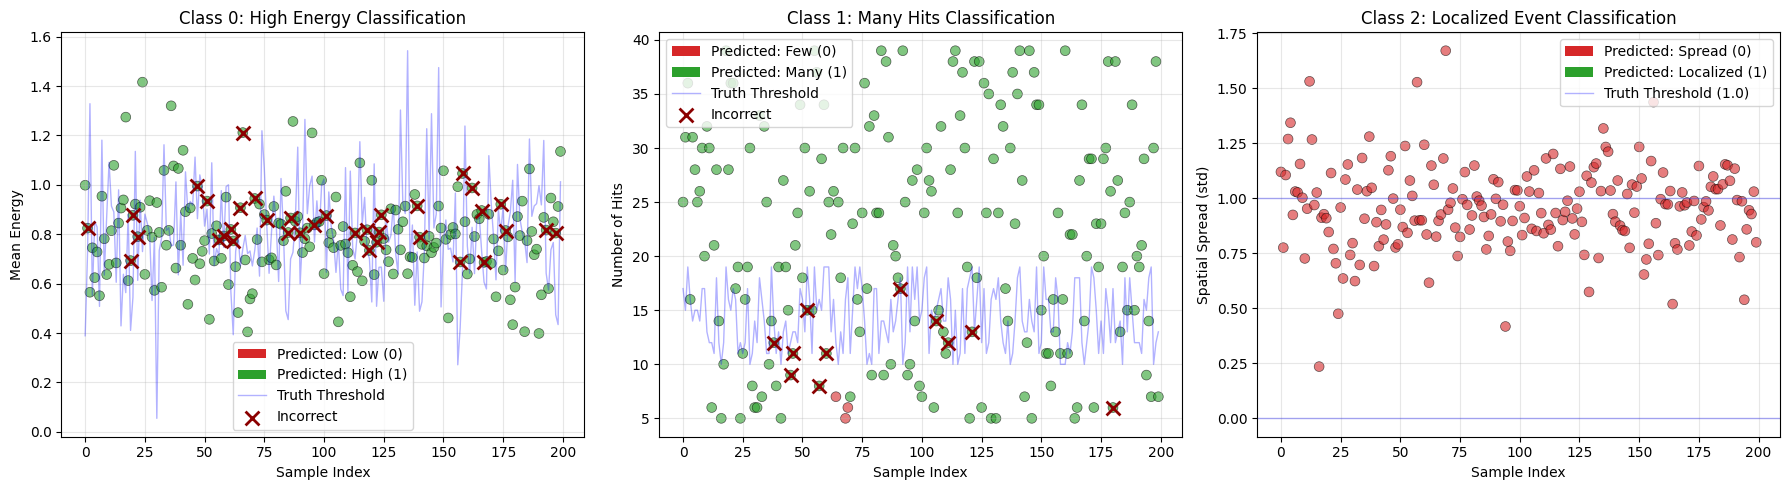


Interpretation:
- Green points: Model predicted class 1 (above threshold)
- Red points: Model predicted class 0 (below threshold)
- Blue line: Ground truth decision boundary
- Red X markers: Incorrect predictions

Good performance = points are green above threshold and red below threshold
val_indices from datamodule: [673, 842, 746, 582, 717, 364, 879, 700, 649, 745, 791, 648, 592, 780, 333, 316, 71, 152, 756, 801, 32, 849, 723, 744, 690, 924, 1, 912, 978, 573, 838, 201, 725, 282, 134, 317, 693, 821, 927, 407, 386, 489, 788, 857, 757, 818, 830, 959, 217, 247]
indices seen in dataloader: [[673, 842, 746, 582], [717, 364, 879, 700], [649, 745, 791, 648], [592, 780, 333, 316], [71, 152, 756, 801], [32, 849, 723, 744], [690, 924, 1, 912], [978, 573, 838, 201], [725, 282, 134, 317], [693, 821, 927, 407], [386, 489, 788, 857], [757, 818, 830, 959], [217, 247, 132, 540], [733, 869, 229, 171], [493, 457, 119, 194], [623, 103, 422, 464], [503, 411, 102, 502], [607, 639, 920, 92], [568, 558, 74

In [14]:
# Get validation indices to extract metadata
val_indices = datamodule.val_dataset.indices
val_records = [records[i] for i in val_indices]

# Extract features and thresholds for validation samples
energy_means = np.array([r["energy_mean"] for r in val_records])
energy_thresholds = np.array([r["energy_threshold"] for r in val_records])
num_hits = np.array([r["num_hits"] for r in val_records])
hit_thresholds = np.array([r["hit_threshold"] for r in val_records])
spatial_spreads = np.array([r["spatial_spread"] for r in val_records])

# Import for legend patches
from matplotlib.patches import Patch

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Class 0: Energy threshold visualization
ax = axes[0]
correct_mask = all_preds[:, 0] == all_labels[:, 0]

# Plot points colored by prediction - use explicit colors for binary classes
colors = ['#d62728' if pred == 0 else '#2ca02c' for pred in all_preds[:, 0]]
scatter = ax.scatter(
    range(len(energy_means)),
    energy_means,
    c=colors,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.5,
    s=50
)

# Plot the individual thresholds as a line
ax.plot(range(len(energy_thresholds)), energy_thresholds,
        'b-', alpha=0.3, linewidth=1, label='Truth Threshold')

# Mark incorrect predictions with X
incorrect_indices = np.where(~correct_mask)[0]
if len(incorrect_indices) > 0:
    ax.scatter(incorrect_indices, energy_means[incorrect_indices],
               marker='x', s=100, c='darkred', linewidths=2, label='Incorrect', zorder=5)

# Add legend
legend_elements = [
    Patch(facecolor='#d62728', label='Predicted: Low (0)'),
    Patch(facecolor='#2ca02c', label='Predicted: High (1)'),
    ax.plot([], [], 'b-', alpha=0.3, linewidth=1)[0],
]
if len(incorrect_indices) > 0:
    legend_elements.append(ax.scatter([], [], marker='x', s=100, c='darkred', linewidths=2))

ax.set_xlabel('Sample Index')
ax.set_ylabel('Mean Energy')
ax.set_title('Class 0: High Energy Classification')
ax.legend(handles=legend_elements, labels=['Predicted: Low (0)', 'Predicted: High (1)', 'Truth Threshold', 'Incorrect'] if len(incorrect_indices) > 0 else ['Predicted: Low (0)', 'Predicted: High (1)', 'Truth Threshold'])
ax.grid(True, alpha=0.3)

# Class 1: Hit count visualization
ax = axes[1]
correct_mask = all_preds[:, 1] == all_labels[:, 1]

# Plot points colored by prediction
colors = ['#d62728' if pred == 0 else '#2ca02c' for pred in all_preds[:, 1]]
scatter = ax.scatter(
    range(len(num_hits)),
    num_hits,
    c=colors,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.5,
    s=50
)

# Plot the individual thresholds
ax.plot(range(len(hit_thresholds)), hit_thresholds,
        'b-', alpha=0.3, linewidth=1, label='Truth Threshold')

# Mark incorrect predictions
incorrect_indices = np.where(~correct_mask)[0]
if len(incorrect_indices) > 0:
    ax.scatter(incorrect_indices, num_hits[incorrect_indices],
               marker='x', s=100, c='darkred', linewidths=2, label='Incorrect', zorder=5)

# Add legend
legend_elements = [
    Patch(facecolor='#d62728', label='Predicted: Few (0)'),
    Patch(facecolor='#2ca02c', label='Predicted: Many (1)'),
    ax.plot([], [], 'b-', alpha=0.3, linewidth=1)[0],
]
if len(incorrect_indices) > 0:
    legend_elements.append(ax.scatter([], [], marker='x', s=100, c='darkred', linewidths=2))

ax.set_xlabel('Sample Index')
ax.set_ylabel('Number of Hits')
ax.set_title('Class 1: Many Hits Classification')
ax.legend(handles=legend_elements, labels=['Predicted: Few (0)', 'Predicted: Many (1)', 'Truth Threshold', 'Incorrect'] if len(incorrect_indices) > 0 else ['Predicted: Few (0)', 'Predicted: Many (1)', 'Truth Threshold'])
ax.grid(True, alpha=0.3)

# Class 2: Spatial spread visualization
ax = axes[2]
correct_mask = all_preds[:, 2] == all_labels[:, 2]

# Plot points colored by prediction
colors = ['#d62728' if pred == 0 else '#2ca02c' for pred in all_preds[:, 2]]
scatter = ax.scatter(
    range(len(spatial_spreads)),
    spatial_spreads,
    c=colors,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.5,
    s=50
)

# Plot the threshold (fixed at 1.0)
ax.axhline(y=1.0, color='b', linestyle='-', alpha=0.3, linewidth=1, label='Truth Threshold (1.0)')

# Mark incorrect predictions
incorrect_indices = np.where(~correct_mask)[0]
if len(incorrect_indices) > 0:
    ax.scatter(incorrect_indices, spatial_spreads[incorrect_indices],
               marker='x', s=100, c='darkred', linewidths=2, label='Incorrect', zorder=5)

# Add legend
legend_elements = [
    Patch(facecolor='#d62728', label='Predicted: Spread (0)'),
    Patch(facecolor='#2ca02c', label='Predicted: Localized (1)'),
    ax.axhline(y=0, color='b', linestyle='-', alpha=0.3, linewidth=1),
]
if len(incorrect_indices) > 0:
    legend_elements.append(ax.scatter([], [], marker='x', s=100, c='darkred', linewidths=2))

ax.set_xlabel('Sample Index')
ax.set_ylabel('Spatial Spread (std)')
ax.set_title('Class 2: Localized Event Classification')
ax.legend(handles=legend_elements, labels=['Predicted: Spread (0)', 'Predicted: Localized (1)', 'Truth Threshold (1.0)', 'Incorrect'] if len(incorrect_indices) > 0 else ['Predicted: Spread (0)', 'Predicted: Localized (1)', 'Truth Threshold (1.0)'])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Green points: Model predicted class 1 (above threshold)")
print("- Red points: Model predicted class 0 (below threshold)")
print("- Blue line: Ground truth decision boundary")
print("- Red X markers: Incorrect predictions")
print("\nGood performance = points are green above threshold and red below threshold")

print("val_indices from datamodule:", val_indices[:50])
print("indices seen in dataloader:", [batch.event_id.tolist() for batch in datamodule.val_dataloader()])
for k in range(10):
    print(k,
          energy_means[k],
          energy_thresholds[k],
          all_labels[k, 0])
